### Objectif

Ce notebook a pour objectif de vous faire pratiquer avec des métriques spécifiquement liées aux problèmes de classification. Dans cette optique, nous allons examiner le jeu de données sur le spam utilisé, nous allons traiter ces données pour ensuite créer un modèle de ML et évaluer le modèle.

Il est important d’avoir une certaine intuition de ce à quoi peut ressembler un message texte indésirable (spam). En général, ces messages contiennent des mots comme « gratuit », « gagner », « gagnant », « argent », « prix » et autres termes similaires, car ils sont conçus pour attirer votre attention et, d’une certaine manière, vous inciter à les ouvrir. De plus, les messages de spam ont souvent des mots écrits en majuscules et utilisent fréquemment de nombreux points d’exclamation. Pour le destinataire, il est généralement assez facile d’identifier un message spam, et notre objectif ici est d’entraîner un modèle à le faire à notre place !

Être capable d’identifier les messages spam est un problème de classification binaire, car les messages sont classés soit comme « Spam », soit comme « Non Spam », et rien d’autre. Il s’agit également d’un problème d’apprentissage supervisé, car nous allons fournir au modèle un jeu de données étiqueté à partir duquel il pourra apprendre afin de faire des prédictions futures.

### Analyse exploratoire des données (EDA)
Nous allons travailler avec un jeu de données tiré du dépôt UCI Machine Learning, connu pour sa large sélection de jeux de données utiles en recherche. Si vous souhaitez en savoir plus, vous pouvez lire le résumé ou consulter le fichier original compressé. Pour cet exercice, les données ont déjà été récupérées pour vous.

Voici un exemple du jeu de données :

<img src="images/dqnb.png" height="1242" width="1242">
Le fichier contient deux colonnes sans nom.

La première indique si le message est un "ham" (non-spam) ou un "spam" (message indésirable).

La seconde contient le texte complet du SMS concerné.

> **Instructions** :

* Importez l’ensemble de données dans un DataFrame pandas à l’aide de la méthode read_table. Le fichier a déjà été téléchargé et vous pouvez y accéder avec le chemin 'smsspamcollection/SMSSpamCollection'. Comme il s’agit d’un fichier séparé par des tabulations, nous allons utiliser '\t' comme valeur de l’argument sep pour indiquer ce format.

Renommez également les noms des colonnes en passant la liste ['label', 'sms_message'] à l’argument names de read_table().

Affichez les cinq premières lignes du DataFrame avec les nouveaux noms de colonnes.

In [8]:
'''
Solution
'''
import pandas as pd
import numpy as np
# Les données sont disponibles dans le chemin'smsspamcollection/SMSSpamCollection'
df = pd.read_table()

# Afficher les  premières lignes
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Traitements des données
Maintenant que nous avons une idée claire de notre jeu de données, nous allons convertir les étiquettes en variables binaires : 0 pour désigner les messages 'ham' (non-spam) et 1 pour ceux marqués comme 'spam'. Cela rendra les calculs plus simples à effectuer.

Pourquoi cette transformation est-elle nécessaire ? Parce que scikit-learn ne fonctionne qu’avec des données numériques. Si nous gardions les étiquettes sous forme de texte, la bibliothèque effectuerait la conversion automatiquement (en transformant les chaînes en nombres flottants non identifiés).

Même si le modèle pourrait quand même faire des prédictions avec des étiquettes textuelles, cela risque de poser des soucis lors de l’évaluation des performances, par exemple pour calculer la précision (precision) ou le rappel (recall). Pour éviter ces problèmes imprévus, il est donc préférable de transformer les valeurs catégorielles en entiers avant de les utiliser dans le modèle.

In [9]:
df['label'] = df.label.map({"spam": 1, "ham": 0})
df.head()

,label,sms_message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Bag of words (sac de mots)
Notre jeu de données consiste en une grande collection de textes (5 572 lignes). Les algorithmes de ML fonctionnent principalement avec des données numériques, et les messages SMS/emails sont généralement riches en texte.

Ici, nous allons introduire le concept de Bag of Words (BoW), qui fait référence à des problèmes impliquant une collection de données textuelles. L’idée derrière BoW est de prendre un texte et de comptabiliser la fréquence des mots qu’il contient. Il est essentiel de comprendre que BoW considère chaque mot indépendamment et que l'ordre des mots n'a pas d'importance.

Grâce à une méthode que nous allons explorer, il est possible de convertir un ensemble de documents en une matrice où chaque document devient une ligne, chaque mot (ou "token") une colonne, et les valeurs (ligne, colonne) correspondent à la fréquence d’apparition de chaque mot dans chaque document.

Par exemple :

Si nous avons les 4 documents suivants :

`['Bonjour, comment vas tu!',
'Gagnez de l'argent depuis votre canapé.',
'Appel moi!',
'Bonjour, je t'appelle demain?']`

L’objectif est de transformer cet ensemble de textes en une matrice de fréquences comme celle-ci :

| Document | appel | appelle | argent | bonjour | canapé | comment | demain | depuis | gagnez | je | l | moi | tu | vas | votre |
|----------|-------|---------|--------|---------|--------|---------|--------|--------|--------|----|---|-----|----|-----|--------|
| Doc 1    | 0     | 0       | 0      | 1       | 0      | 1       | 0      | 0      | 0      | 0  | 0 | 0   | 1  | 1   | 0      |
| Doc 2    | 0     | 0       | 1      | 0       | 1      | 0       | 0      | 1      | 1      | 0  | 1 | 0   | 0  | 0   | 1      |
| Doc 3    | 1     | 0       | 0      | 0       | 0      | 0       | 0      | 0      | 0      | 0  | 0 | 1   | 0  | 0   | 0      |
| Doc 4    | 0     | 1       | 0      | 1       | 0      | 0       | 1      | 0      | 0      | 1  | 0 | 0   | 0  | 0   | 0      |

Ici, on voit que les documents sont listés sur les lignes, chaque mot figure en colonne, et la valeur dans chaque case est la fréquence de ce mot dans le document.


Pour cela, nous utiliserons la méthode [count vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) de la bibliothèque sklearn qui fait ce qui suit :

* Elle découpe le texte en mots individuels et attribue un identifiant à chaque mot.
* Elle compte la fréquence de chaque mot dans le texte.

**Points importants** :
* CountVectorizer convertit automatiquement tous les mots en minuscules, ce qui évite de traiter des mots comme 'He' et 'he' de façon différente. Cela est géré par le paramètre `lowercase` (par défaut à True).

* Elle ignore la ponctuation, ce qui signifie que des mots suivis de signes de ponctuation (exemple : 'hello!') ne sont pas distingués des mêmes mots sans ponctuation (exemple : 'hello'). Cela se fait via le paramètre `token_pattern`, qui utilise une expression régulière sélectionnant les tokens de 2 caractères ou plus.

* Un paramètre important est celui des `stop_words`. Les mots vides (comme 'an', 'the', 'a', etc.) sont automatiquement ignorés si on règle ce paramètre sur `english`, car ces mots n'apportent généralement pas d'information utile pour identifier des mots-clés dans le spam.

Nous aborderons l’application de ces paramètres dans notre modèle dans une étape ultérieure, mais pour l’instant, il est important de connaître ces techniques de prétraitement lors de l’analyse de données textuelles.

### Implémentez bag of words avec scikit learn
Ici, nous allons créer une matrice de fréquences sur un petit ensemble de documents afin de bien comprendre comment se génère la matrice document-terme. Nous avons créé un ensemble de documents d'exemple appelé documents.

In [11]:
documents = ['Hello, how are you!',
                'Win money, win from home.',
                'Call me now.',
                'Hello, Call hello you tomorrow?']

>**Instructions:**
Importez le module sklearn.feature_extraction.text.CountVectorizer et instanciez 'count_vector'. 

In [10]:
'''
Solution
'''
from sklearn.feature_extraction.text import CountVectorizer
count_vector =  # TODO instatier CountVectorizor

**Traitement des données avec CountVectorizer()**
CountVectorizer() prétaite automatiquement les données grâce aux paramètres ci-dessous:
* `lowercase = True`  
      
    Le paramètre `lowercase` a pour valeur par défaut `True`, ce qui convertit tout notre texte en minuscules.

* `token_pattern = (?u)\\b\\w\\w+\\b`  
      
    Le paramètre `token_pattern` utilise par défaut l'expression régulière `(?u)\\b\\w\\w+\\b`, qui ignore tous les signes de ponctuation en les considérant comme des délimiteurs, tout en acceptant les chaînes alphanumériques d'une longueur supérieure ou égale à 2 comme des tokens ou mots individuels.

* `stop_words`  
      
    Le paramètre `stop_words`, s’il est défini à `english`, supprimera tous les mots de notre ensemble de documents qui correspondent à une liste de mots vides en anglais, définie dans scikit-learn. Étant donné la taille de notre jeu de données et le fait que nous travaillons avec des messages SMS et non des sources textuelles plus longues comme les e-mails, nous ne définirons pas de valeur pour ce paramètre.


> **Instructions :**  
Utilisez la méthode `fit()` pour ajuster votre ensemble de documents à l’objet `CountVectorizer` que vous avez créé, puis récupérez la liste des mots qui ont été identifiés comme caractéristiques à l’aide de la méthode `get_feature_names()`.

In [12]:
# TODO : utilisez la méthode fit de count_vectorizer pour ajuster les données

# TODO : Utiliser la méthode get_feature_names_out() pour obtenir la liste des mots


array(['are', 'call', 'from', 'hello', 'home', 'how', 'me', 'money',
       'now', 'tomorrow', 'win', 'you'], dtype=object)

La méthode `get_feature_names_out()` renvoie les noms des caractéristiques (features) pour ce jeu de données, c’est-à-dire l’ensemble des mots qui constituent le vocabulaire de `documents`.

> **Instructions :**  
Créez une matrice dont les lignes représentent chacun des 4 documents, et dont les colonnes correspondent à chaque mot. La valeur à l’intersection (ligne, colonne) indique la fréquence d’apparition de ce mot (colonne) dans un document spécifique (ligne). Vous pouvez faire cela en utilisant la méthode `transform()` en lui passant l’ensemble des documents comme argument. Cette renvoie une matrice d'entiers NumPy. Vous pouvez la convertir en tableau avec `toarray()`. Nommez ce tableau **doc_array**.

In [15]:
doc_array = # TODO : Transformer les données avec la méthode transform 
doc_array.toarray()

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1]], dtype=int64)

Nous avons maintenant une représentation claire des documents sous forme de distribution de fréquence des mots qu’ils contiennent.  
Pour faciliter la compréhension, la prochaine étape consiste à convertir ce tableau en DataFrame et à nommer les colonnes de manière appropriée.

> **Instructions :**  
Convertissez le tableau que nous avons obtenu, stocké dans `doc_array`, en un DataFrame,  
et définissez les noms des colonnes comme étant les mots (que vous avez obtenus précédemment avec `get_feature_names_out()`). Nommez ce DataFrame `frequency_matrix`.

In [16]:
# TODO M Créer un DataFrame avec les données doc_array
frequency_matrix = pd.DataFrame(, columns=)
frequency_matrix

,are,call,from,hello,home,how,me,money,now,tomorrow,win,you
0,1,0,0,1,0,1,0,0,0,0,0,1
1,0,0,1,0,1,0,0,1,0,0,2,0
2,0,1,0,0,0,0,1,0,1,0,0,0
3,0,1,0,2,0,0,0,0,0,1,0,1


Félicitations ! Vous avez implémenté avec succès un modèle **Bag of Words** sur un ensemble de documents que nous avons créé.

Un problème potentiel qui peut survenir en utilisant cette méthode telle quelle,  
c’est que si notre ensemble de données textuelles est très volumineux (par exemple, une grande collection d’articles de presse ou d’e-mails),  
certains mots apparaîtront beaucoup plus fréquemment que d’autres simplement en raison de la structure naturelle de la langue.  
Par exemple, des mots comme *"le"*, *"la"*, *"l'"*, les pronoms ou certaines constructions grammaticales  
peuvent fausser notre matrice et affecter notre analyse.

Il existe plusieurs façons d’atténuer ce problème.  
Une méthode consiste à utiliser le paramètre `stop_words` en le définissant à `english`.  
Cela permettra d’ignorer automatiquement tous les mots de notre texte d’entrée qui figurent dans la liste intégrée des **stop words** en anglais de scikit-learn.

Une autre façon de gérer ce biais est d’utiliser la méthode [`tfidf`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer). Cette méthode sort toutefois du cadre de cette leçon.


### Ensemble d'entraînement et ensemble de test
Maintenant que nous avons compris comment gérer le problème du **Bag of Words**,  
nous pouvons revenir à notre jeu de données et poursuivre notre analyse.  

La première étape dans ce processus consistera à **diviser notre jeu de données en un ensemble d'entraînement et un ensemble de test**,  
afin de pouvoir évaluer notre modèle par la suite.

> **Instructions :**  
Divisez le jeu de données en un ensemble d'entraînement et un ensemble de test en utilisant la fonction `train_test_split` de scikit-learn.  
Effectuez la séparation avec les variables suivantes :

* `X_train` : données d'entraînement pour la colonne `sms_message`  
* `y_train` : données d'entraînement pour la colonne `label`  
* `X_test` : données de test pour la colonne `sms_message`  
* `y_test` : données de test pour la colonne `label`  

Affichez le nombre de lignes dans chacun des ensembles d'entraînement et de test.

In [17]:
'''
Solution
'''
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(,  # Liste des messages
                                                    ,  # Label spam ou pas spam
                                                    random_state=1)

print('Nombre total du jeu de donnée: {}'.format(df.shape[0]))
print('Nombre total du jeu d\'entraînement: {}'.format(X_train.shape[0]))
print('Nombre total du jeu de teste: {}'.format(X_test.shape[0]))

Nombre total du jeu de donnée: 5572
Nombre total du jeu d'entraînement: 4179
Nombre total du jeu de teste: 1393


### Application du traitement Bag of Words à notre jeu de données ###

Maintenant que nous avons divisé les données, notre objectif est de suivre les étapes de l’Étape 2 : Bag of Words  
et de convertir nos données au format matriciel souhaité.  
Pour cela, nous allons utiliser `CountVectorizer()` comme nous l’avons fait précédemment.

Deux étapes sont à prendre en compte ici :

* Premièrement, nous devons ajuster nos données d’entraînement (`X_train`) avec `CountVectorizer()` et obtenir la matrice.  
* Deuxièmement, nous devons transformer nos données de test (`X_test`) pour obtenir également la matrice.

Notez que `X_train` correspond à nos données d’entraînement de la colonne `sms_message` du jeu de données,  
et que nous allons les utiliser pour entraîner notre modèle.

`X_test` correspond à nos données de test de la colonne `sms_message`.  
C’est ce jeu que nous allons utiliser (après transformation en matrice) pour effectuer des prédictions.  
Nous comparerons ensuite ces prédictions à `y_test` dans une étape ultérieure.

Pour l’instant, le code qui réalise les transformations matricielles vous est fourni !


In [28]:
'''
Le code de cette section est divisé en deux parties.  
Premièrement, nous apprenons un dictionnaire de vocabulaire à partir des données d’entraînement  
puis nous transformons ces données en une matrice document-terme ;  

deuxièmement, pour les données de test, nous nous contentons de les transformer en matrice document-terme.
'''

count_vector = CountVectorizer()

# TODO : Ajuster les données d'entraînement et retourner la matrice
training_data = 

# TODO: Transformer les données de test et retourner la matrice.
# Remarque : on ne fait pas de fit sur les données de test avec CountVectorizer()
testing_data = 

In [27]:
pd.DataFrame(testing_data.toarray(), columns=count_vector.get_feature_names_out())

,00,000,000pes,0089,02,03,04,05,050703,0578,...,youuuuu,yoville,yr,yrs,ystrday,yun,yup,yupz,zogtorius,ú1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Apprentissage
Maintenant que les données sont tous traités, nous allons effectués l'apprentissage de plusieurs modèles à la fois.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC

# Instancier plusieurs modèles
naive_bayes = MultinomialNB()
bag_mod = BaggingClassifier(n_estimators=200)
rf_mod = RandomForestClassifier(n_estimators=200)
ada_mod = AdaBoostClassifier(n_estimators=300, learning_rate=0.2)
svm_mod = SVC()

> **Étape 1** : Maintenant, ajustez chacun des modèles ci-dessus sur les données appropriées.  
Répondez à la question suivante pour vérifier que vous avez correctement ajusté les modèles.

In [31]:
# Ajuster les modèles avec la méthode fit de scikit learn
# TODO: Pour chaque modèle ajouter en paramètre l'ensemble d'entraînement et les données cibles
naive_bayes.fit(, )
bag_mod.fit(, )
rf_mod.fit(, )
ada_mod.fit(, )
svm_mod.fit(, )

SVC()

> **Étape 2** : Maintenant, effectuez des prédictions avec chacun de vos modèles sur les données qui vous permettront de comprendre la capacité de généralisation de notre modèle sur de nouvelles données.  
Puis, ajoutez correctement les chaînes de caractères dans l’ensemble (set) dans la cellule suivante.

In [32]:
# Effectuer une prédiction avec chaque modèle
# TODO: Pour chaque modèle ajouter en paramètre l'ensemble des données test
y_preds_naive = naive_bayes.predict()
y_preds_bag = bag_mod.predict()
y_preds_rf = rf_mod.predict()
y_preds_ada = ada_mod.predict()
y_preds_svm = svm_mod.predict()

### Evaluation
Maintenant que vous avez effectué toutes vos prédictions, passons aux sujets abordés dans cette leçon :  
mesurer la performance de chacun de vos modèles.  

Dans un premier temps, nous allons nous concentrer sur le calcul de chaque métrique pour un modèle unique,  
puis, dans la dernière partie de ce notebook, vous choisirez les modèles les plus performants selon une métrique donnée.

Vous allez écrire des fonctions pour calculer plusieurs métriques,  
puis comparer vos résultats avec ceux obtenus via scikit-learn.  
Cela vous aidera à mieux comprendre le calcul de chaque métrique.

> **Étape 3** :  
À titre d'exemple pour les questions suivantes, exécutez la cellule ci-dessous.  
Complétez la fonction ci-dessous pour calculer la précision (accuracy),  
puis comparez votre résultat avec la fonction intégrée afin de vérifier sa justesse.

In [34]:
# accuracy c'est le nombre de total des correctes divisisé par le nombre total de prédiction
def accuracy(actual, preds):
    '''
    INPUT
    preds - predictions as a numpy array or pandas series
    actual - actual values as a numpy array or pandas series
    
    OUTPUT:
    returns the accuracy as a float
    '''
    return np.sum(preds == actual)/len(actual)


print(accuracy(y_test, y_preds_naive))
print(accuracy_score(y_test, y_preds_naive))
print("Tant que les valeurs nous avons bien calculé notre métriques!")

0.9885139985642498
0.9885139985642498
Tant que les valeurs nous avons bien calculé notre métriques!


> **Étape 4** : Remplissez la fonction ci-dessous pour calculer la précision, puis comparez votre réponse à celle intégrée pour vous assurer que vous avez raison.

In [37]:
# preicision égale le nombre de vrai positifs divisé le nombre des valeurs positives prédites (VP/VP+FP)
def precision(actual, preds):
    '''
    INPUT
    (assumes positive = 1 and negative = 0)
    preds - predictions as a numpy array or pandas series 
    actual - actual values as a numpy array or pandas series
    
    OUTPUT:
    returns the precision as a float
    '''
    # TODO: Remplir l'égalité dans la fonction np.where
    true_pos = len(np.intersect1d(np.where(==), np.where(==))) 
    # TODO : Remplir l'égalité
    pred_pos = (==).sum()
    # TODO : Calculer la précision à partir des deux variables
    return true_pos/pred_pos 

print(precision(y_test, y_preds_naive))
print(precision_score(y_test, y_preds_naive))

print("C'est OK, si les résultats sont les mêmes!")

0.9720670391061452
0.9720670391061452
C'est OK, si les résultats sont les mêmes!


> **Étape 5** : Remplissez la fonction ci-dessous pour calculer le rappel, puis comparez votre réponse à celle intégrée pour vous assurer que vous avez raison.

In [38]:
# recall c'est le nombre de vrais positifs sur tous les valeurs positifs (TP/TP+FN)
def recall(actual, preds):
    '''
    INPUT
    preds - predictions as a numpy array or pandas series
    actual - actual values as a numpy array or pandas series
    
    OUTPUT:
    returns the recall as a float
    '''
    # TODO: Remplir l'égalité dans la fonction np.where
    true_pos = len(np.intersect1d(np.where(==), np.where(==)))
    # TODO : Remplir l'égalité
    actual_pos = (==).sum()
    # TODO : Calculer le recall à partir des deux variables
    return 

print(recall(y_test, y_preds_naive))
print(recall_score(y_test, y_preds_naive))
print("C'est OK, si les résultats sont les mêmes!")

0.9405405405405406
0.9405405405405406
C'est OK, si les résultats sont les mêmes!


> **Étape 6** : Remplissez la fonction ci-dessous pour calculer le score f1, puis comparez votre réponse à celle intégrée pour vous assurer que vous avez raison.

In [45]:
def f1(preds, actual):
    '''
    INPUT
    preds - predictions as a numpy array or pandas series
    actual - actual values as a numpy array or pandas series
    
    OUTPUT:
    returns the f1score as a float
    '''
    prec = precision(actual, preds) 
    rec = recall(actual, preds)
    # TODO : Calculer le score f1
    return 


print(f1(y_test, y_preds_naive))
print(f1_score(y_test, y_preds_naive))
print("C'est OK, si les résultats sont les mêmes!")

0.9560439560439562
0.9560439560439562
C'est OK, si les résultats sont les mêmes!


> **Étape 7** : Maintenant que vous avez calculé plusieurs indicateurs, identifions les cas où nous pourrions les utiliser. Utilisez le dictionnaire ci-dessous pour associer un indicateur à chaque énoncé qui identifie le cas où vous souhaitez l'utiliser.

In [51]:
df['label'].value_counts(normalize=True)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64

In [ ]:
a = "recall"
b = "precision"
c = "accuracy"
d = 'f1-score'


seven_sol = {
'Nous avons des labels non homogènes, quelle métrique nous ne devrons pas utiliser ?': ,
'Nous aimerons être sûre que tous les cas positifs sont détectés': , 
'Nous devons être si le cas détecté est positif c\'est vraiment positif': ,
'Nous aimerons repérer à la fois les cas positifs et négatifs': 
}

> **Étape 8 :** Compte tenu de ce que vous savez maintenant sur les métriques, utilisez ces informations pour faire correspondre correctement le modèle approprié au moment où il serait préférable d’utiliser chacune d’elles dans le dictionnaire ci-dessous.

In [ ]:
a = "naive-bayes"
b = "bagging"
c = "random-forest"
d = 'ada-boost'
e = "svm"

eight_sol = {
'Nous avons des labels non homogènes, quelle métrique nous ne devrons pas utiliser ?': , 
'Nous aimerons être sûre que tous les cas positifs sont détectés': , 
'Nous devons être si le cas détecté est positif c\'est vraiment positif': , 
'Nous aimerons repérer à la fois les cas positifs et négatifs': 
}

In [48]:
# Cellule pour tester
def print_metrics(y_true, preds, model_name=None):
    '''
    INPUT:
    y_true - the y values that are actually true in the dataset (numpy array or pandas series)
    preds - the predictions for those values from some model (numpy array or pandas series)
    model_name - (str - optional) a name associated with the model if you would like to add it to the print statements 
    
    OUTPUT:
    None - prints the accuracy, precision, recall, and F1 score
    '''
    if model_name == None:
        print('Accuracy score: ', format(accuracy_score(y_true, preds)))
        print('Precision score: ', format(precision_score(y_true, preds)))
        print('Recall score: ', format(recall_score(y_true, preds)))
        print('F1 score: ', format(f1_score(y_true, preds)))
        print('\n\n')
    
    else:
        print('Accuracy score ' + model_name + ' :' , format(accuracy_score(y_true, preds)))
        print('Precision score ' + model_name + ' :', format(precision_score(y_true, preds)))
        print('Recall score ' + model_name + ' :', format(recall_score(y_true, preds)))
        print('F1 score ' + model_name + ' :', format(f1_score(y_true, preds)))
        print('\n\n')

In [49]:
print_metrics(y_test, y_preds_naive, model_name="Naive Bayes")
print_metrics(y_test, y_preds_ada, model_name="Ada Boost")
print_metrics(y_test, y_preds_bag, model_name="Bagging")
print_metrics(y_test, y_preds_rf, model_name="Random forest")
print_metrics(y_test, y_preds_svm, model_name="SVM")


Accuracy score Naive Bayes : 0.9885139985642498
Precision score Naive Bayes : 0.9720670391061452
Recall score Naive Bayes : 0.9405405405405406
F1 score Naive Bayes : 0.9560439560439562



Accuracy score Ada Boost : 0.9770279971284996
Precision score Ada Boost : 0.9693251533742331
Recall score Ada Boost : 0.8540540540540541
F1 score Ada Boost : 0.9080459770114943



Accuracy score Bagging : 0.9755922469490309
Precision score Bagging : 0.9171270718232044
Recall score Bagging : 0.8972972972972973
F1 score Bagging : 0.907103825136612



Accuracy score Random forest : 0.9820531227566404
Precision score Random forest : 1.0
Recall score Random forest : 0.8648648648648649
F1 score Random forest : 0.927536231884058



Accuracy score SVM : 0.9849246231155779
Precision score SVM : 0.9939759036144579
Recall score SVM : 0.8918918918918919
F1 score SVM : 0.9401709401709402





Pour terminer cette guide pratique, examinons les trois dernières mesures que vous avez vues : f-beta score, les ROC curve et l'ASC.

**Pour les f-beta score:** Si vous privilégiez la précision, rapprochez la valeur beta de 0. Si vous privilégiez le rappel, rapprochez la valeur bêta de l'infini.

> **Étape 9** : L'utilisation de fbeta_score fonctionne de manière similaire à la plupart des autres métriques de sklearn, mais vous devez également définir beta comme pondération entre la précision et le rappel. Utilisez l'espace ci-dessous pour montrer que vous pouvez utiliser [fbeta dans sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html) pour reproduire votre score f1 ci-dessus. Si vous souhaitez utiliser une pondération différente à l'avenir, [cet article](http://mlwiki.org/index.php/Precision_and_Recall) explique très bien comment ajuster beta à différentes situations.

In [57]:
# importer fbeta_score
from sklearn.metrics import fbeta_score

# TODO: Reproduisez le résultat de f1-score en utilisant f-beta score
fb_score = 
print(fb_score)

0.927536231884058


> **Étape 10** : Créer des courbes ROC en Python est un processus assez complexe. J'ai écrit la fonction ci-dessous pour vous faciliter la tâche et vous permettre de le faire plus facilement à l'avenir. Essayez-la avec l'un des autres classificateurs que vous avez créés ci-dessus pour comparer son fonctionnement au modèle de random forest ci-dessous.

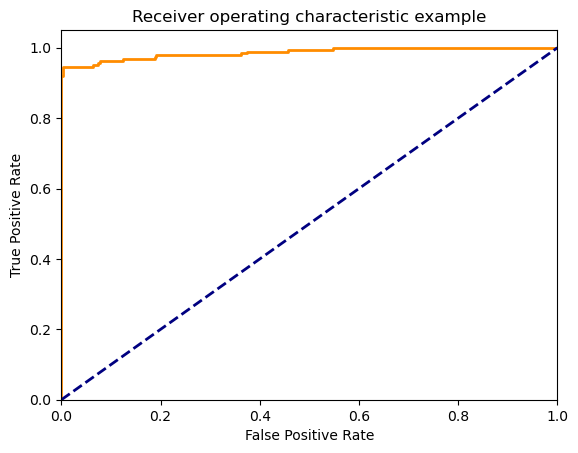

0.9682007338464294

In [59]:
def build_roc_auc(model, X_train, X_test, y_train, y_test):
    '''
    INPUT:
    model - an sklearn instantiated model
    X_train - the training data
    y_train - the training response values (must be categorical)
    X_test - the test data
    y_test - the test response values (must be categorical)
    OUTPUT:
    auc - returns auc as a float
    prints the roc curve
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    from scipy import interp
    
    y_preds = model.fit(X_train, y_train).predict_proba(X_test)
    # Calcule du ROC curve et de l'aire du courbe pour chaque classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_preds[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calculer la courbe ROC micro-moyenne et la surface ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds[:, 1].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.show()
    
    return roc_auc_score(y_test, np.round(y_preds[:, 1]))
    
    
# ROC et AUC du modèle random forest    
build_roc_auc(naive_bayes, training_data, testing_data, y_train, y_test) 

In [ ]:
# À votre tour ici - choisissez un autre classificateur pour voir comment il se compare


